In [1]:
import math
from pathlib import Path

import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import rasterio.coords
from numpy.typing import NDArray
from rasterio.transform import Affine
from rasterstats import zonal_stats
from tqdm import tqdm

## Vectorize SUFOSAT data


### Create a new binary TIFF file for the 2024 clear cuts


In [2]:
def regroup_sufosat_days(
    input_tif_filepath: str | Path,
    output_tif_filepath: str | Path,
    start_day: pd.Timestamp,
    end_day: pd.Timestamp,
) -> None:
    # Each pixel's value represent the number of days since 03/04/2014
    # We are going to bin the pixels' value to 0 or .
    # For example, for 2024, pixel values between 3560 and 3925 will be 1, and 0 otherwise
    sufosat_start_day = pd.Timestamp(year=2014, month=4, day=3)
    start_days = (start_day - sufosat_start_day).days
    end_days = (end_day - sufosat_start_day).days

    # Open the input TIFF file
    with rasterio.open(input_tif_filepath) as src:
        # Copy metadata
        profile = src.profile
        # Change from uint16 to uint 8 since we'll only store zeros one ones
        profile.update(dtype=rasterio.uint8)

        # Open the output TIFF file
        with rasterio.open(output_tif_filepath, "w", **profile) as dst:
            # Read the data as a generator (window-by-window) to avoid out Of memory issues
            # since the total grid contains billions of points
            for _, window in tqdm(
                src.block_windows(),
                total=src.width
                * src.height
                // (src.block_shapes[0][0] * src.block_shapes[0][1]),
            ):
                # Read the block data for the first and only band
                data = src.read(1, window=window)

                # Apply the date filter to create binary image (0 or 1)
                binary_data = ((data >= start_days) & (data <= end_days)).astype(np.uint8)

                # Write processed block to new file
                dst.write(binary_data, 1, window=window)


# Create a new TIFF file for 2024 clear cuts
# This should take 1 to 2 minutes
regroup_sufosat_days(
    # Download from "mosaics_tropisco_warnings_france_date.tif" from https://zenodo.org/records/13685177
    "data/sufosat/mosaics_tropisco_warnings_france_date.tif",
    "data/sufosat/mosaics_tropisco_warnings_france_date_2024.tif",
    pd.Timestamp(year=2024, month=1, day=1),
    pd.Timestamp(year=2024, month=12, day=31),
)

15458it [01:28, 174.68it/s]                           


### Polygonize the TIFF file


In [3]:
# Use gdal_polygonize.py to easily transform the TIFF file into a Shapefile
# Maybe we could use the default 4-connectivity instead of 8-connectivity to have simpler clear cuts polygons?
# See documentation: https://gdal.org/en/stable/programs/gdal_polygonize.html
# This requires GDAL installed (I have version 3.0.4 on Ubuntu 20.04)
# This should take 2 to 3 minutes
!mkdir data/sufosat/sufosat_2024/
!gdal_polygonize.py -8 data/sufosat/mosaics_tropisco_warnings_france_date_2024.tif data/sufosat/sufosat_2024/sufosat_2024.shp

Creating output data/sufosat/sufosat_2024/sufosat_2024.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.
free(): invalid pointer


## Add new data sources for Canopée abusive clear cuts criterias

Abusive clear cut criterias:

- Area >= 10 hectares
- Area >= 2 hectares within a protected natural area (e.g., Natura 2000)
- Area >= 2 hectares and slope >= 30%


In [2]:
sufosat_2024: gpd.GeoDataFrame = gpd.read_file("data/sufosat/sufosat_2024/")
# We only need geometries since this data is for 2024 only
sufosat_2024 = sufosat_2024.drop(columns="DN")
sufosat_2024

,geometry
0,"POLYGON ((3.80855 51.44248, 3.80879 51.44248, ..."
1,"POLYGON ((3.80831 51.44239, 3.80843 51.44239, ..."
2,"POLYGON ((3.80891 51.44157, 3.80903 51.44157, ..."
3,"POLYGON ((3.84416 51.42064, 3.84428 51.42064, ..."
4,"POLYGON ((3.84775 51.42046, 3.84799 51.42046, ..."
...,...
51912,"POLYGON ((9.34694 41.12375, 9.34766 41.12375, ..."
51913,"POLYGON ((9.28148 41.11832, 9.28172 41.11832, ..."
51914,"POLYGON ((9.28316 41.11705, 9.28328 41.11705, ..."
51915,"POLYGON ((9.36468 41.1059, 9.3654 41.1059, 9.3..."


### Keep clear cuts with area >= 2ha


In [3]:
# Calculate the area in square meters and convert to hectares (with 1 ha = 10 000 m²)
# Convert the geometry to the EPSG:3395 (World Mercator) CRS, which uses meters as units for accurate area calculation
sufosat_2024["area_ha"] = sufosat_2024.to_crs(epsg=3395).geometry.area / 10000
sufosat_2024

,geometry,area_ha
0,"POLYGON ((3.80855 51.44248, 3.80879 51.44248, ...",0.043094
1,"POLYGON ((3.80831 51.44239, 3.80843 51.44239, ...",0.043094
2,"POLYGON ((3.80891 51.44157, 3.80903 51.44157, ...",0.021547
3,"POLYGON ((3.84416 51.42064, 3.84428 51.42064, ...",0.021537
4,"POLYGON ((3.84775 51.42046, 3.84799 51.42046, ...",0.086147
...,...,...
51912,"POLYGON ((9.34694 41.12375, 9.34766 41.12375, ...",0.142460
51913,"POLYGON ((9.28148 41.11832, 9.28172 41.11832, ...",0.284896
51914,"POLYGON ((9.28316 41.11705, 9.28328 41.11705, ...",0.053417
51915,"POLYGON ((9.36468 41.1059, 9.3654 41.1059, 9.3...",0.338250


In [4]:
# Only keep the clear cuts >= 2 hectares
sufosat_2024: gpd.GeoDataFrame = (
    sufosat_2024[sufosat_2024["area_ha"] >= 2].sort_values("area_ha").reset_index(drop=True)
)
sufosat_2024

,geometry,area_ha
0,"POLYGON ((0.85682 48.35892, 0.8573 48.35892, 0...",2.000293
1,"POLYGON ((0.68573 45.22288, 0.68597 45.22288, ...",2.000648
2,"POLYGON ((-0.97956 44.6865, -0.97944 44.6865, ...",2.000784
3,"POLYGON ((3.64202 45.23294, 3.64214 45.23294, ...",2.000969
4,"POLYGON ((2.48698 48.88677, 2.48734 48.88677, ...",2.001035
...,...,...
6496,"POLYGON ((-1.18134 44.59514, -1.18086 44.59514...",66.237954
6497,"POLYGON ((-1.19201 44.54103, -1.19189 44.54103...",67.776518
6498,"POLYGON ((-0.4337 44.15538, -0.43346 44.15538,...",75.445972
6499,"POLYGON ((-0.77599 44.62886, -0.77575 44.62886...",87.825707


### Check if some clear cuts occured in Natura 2000 zones

Download data from https://inpn.mnhn.fr/telechargement/cartes-et-information-geographique/nat/natura


,SITECODE,SITENAME,geometry
0,FR1100795,Massif de Fontainebleau,"MULTIPOLYGON (((676175.872 6795700.969, 676137..."
1,FR1100796,Forêt de Rambouillet,"MULTIPOLYGON (((605515.333 6842524.165, 605671..."
2,FR1100797,Coteaux et boucles de la seine,"MULTIPOLYGON (((604911.379 6882649.249, 604913..."
3,FR1100799,Haute vallée de l'Essonne,"MULTIPOLYGON (((660383.355 6798249.709, 660363..."
4,FR1100800,Pelouses calcaires de la haute vallée de la Juine,"MULTIPOLYGON (((636679.501 6808009.656, 636658..."
...,...,...,...
1350,FR7200749,Montagnes du Barétous,"MULTIPOLYGON (((386390.085 6229883.827, 386408..."
1351,FR7200752,Massif des Arbailles,"MULTIPOLYGON (((371351.236 6228235.37, 371261...."
1352,FR7200750,Montagnes de la Haute Soule,"MULTIPOLYGON (((371771.269 6223499.348, 371875..."
1353,FR9101413,Posidonies de la côte palavasienne,"POLYGON ((764008.157 6255745.243, 762998.071 6..."


<Axes: >

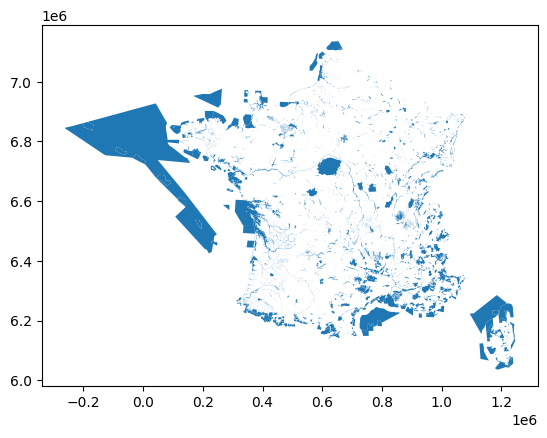

In [5]:
# "Sites classés au titre de la Directive Habitats : périmètres transmis à la CE (ZSC/pSIC/SIC)"
# https://inpn.mnhn.fr/docs/Mapinfo/sic.zip
nat2000_sic = gpd.read_file("data/natura2000/sic.zip")
display(nat2000_sic)
nat2000_sic.plot()

,SITECODE,SITENAME,geometry
0,FR1110025,Etang de Saint Quentin,"POLYGON ((627623.168 6854888.067, 627620.379 6..."
1,FR1110795,Massif de Fontainebleau,"MULTIPOLYGON (((676175.872 6795700.969, 676137..."
2,FR1112001,Massif de Villefermoy,"MULTIPOLYGON (((699069.343 6818948.132, 698740..."
3,FR1112002,Bassée et plaines adjacentes,"MULTIPOLYGON (((694175.145 6809356.113, 694235..."
4,FR1112003,Boucles de la Marne,"MULTIPOLYGON (((682023.381 6867529.807, 681995..."
...,...,...,...
402,FR9112025,Complexe lagunaire de Canet-Saint Nazaire,"POLYGON ((702907.22 6171734.055, 702907.808 61..."
403,FR9112019,Montagne de l'Espinouse et du Caroux,"MULTIPOLYGON (((691239.65 6281608.207, 691273...."
404,FR5212003,Vallée de la Loire des Ponts-de-Cé à Montsoreau,"MULTIPOLYGON (((455607.074 6698179.23, 455591...."
405,FR9112034,Cap Bear- cap Cerbère,"POLYGON ((711051.78 6153578.286, 711052.321 61..."


<Axes: >

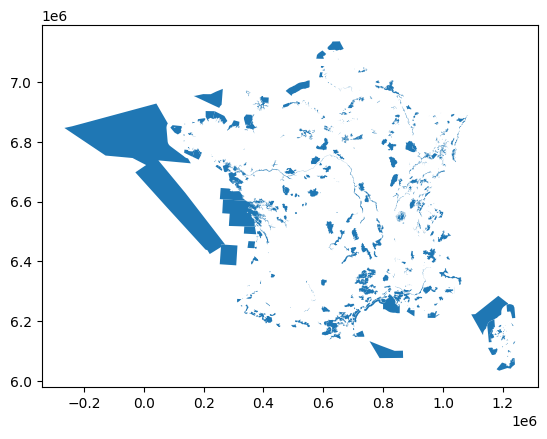

In [6]:
# "Zones de protection spéciale (ZPS)"
# https://inpn.mnhn.fr/docs/Shape/zps.zip
nat2000_zps = gpd.read_file("data/natura2000/zps.zip")
display(nat2000_zps)
nat2000_zps.plot()

,geometry
0,"POLYGON ((317766.398 6260743.551, 317798.001 6..."
1,"POLYGON ((321087.848 6259077.852, 321050.71 62..."
2,"POLYGON ((321049.916 6259506.28, 321061.857 62..."
3,"POLYGON ((222235.151 6425916.243, 220496.621 6..."
4,"POLYGON ((350925.078 6599683.636, 350930.265 6..."
...,...
7344,"POLYGON ((1226164.86 6195358.743, 1226164.928 ..."
7345,"POLYGON ((1219473.509 6196094.104, 1219450.895..."
7346,"POLYGON ((1226717.332 6211898.684, 1226684.19 ..."
7347,"POLYGON ((1217249.6 6229586.4, 1217250 6229586..."


<Axes: >

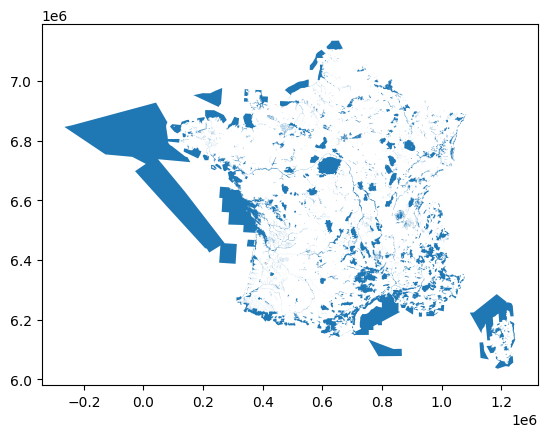

In [7]:
# For now, we just union_all all the areas for simplicity
# Eventually, we want to keep the site codes and names

if Path("data/natura2000/nat2000/nat2000.shp").exists():
    nat2000 = gpd.read_file("data/natura2000/nat2000/").drop(columns="FID")
else:
    # This should take 1 to 2 minutes
    nat2000 = gpd.GeoDataFrame(
        geometry=[pd.concat([nat2000_sic, nat2000_zps]).union_all()], crs=nat2000_sic.crs
    )
    # Explode the multipolygon to get the individual polygons (one for each site)
    nat2000 = nat2000.explode()
    # Save to disk for future reuse
    Path("data/natura2000/nat2000/").mkdir(exist_ok=True, parents=True)
    nat2000.to_file("data/natura2000/nat2000/nat2000.shp")

display(nat2000)
nat2000.plot()

In [8]:
# We need to use the same CRS before spatial join
nat2000 = nat2000.to_crs(sufosat_2024.crs)
nat2000["nat2000_geometry"] = nat2000["geometry"]

# Join both geodataframes
# This should take a minute
sufosat_2024: gpd.GeoDataFrame = gpd.sjoin(
    sufosat_2024, nat2000.to_crs(sufosat_2024.crs), how="left", predicate="intersects"
)

# Create the intersection geometry of sufosat and nat2000
# geometry = sufosat geometry since it's a left join
sufosat_2024["nat2000_intersection_geometry"] = sufosat_2024["geometry"].intersection(
    sufosat_2024["nat2000_geometry"]
)

# Keep relevant columns
sufosat_2024 = sufosat_2024[
    ["geometry", "area_ha", "nat2000_intersection_geometry", "nat2000_geometry"]
]

# Add the Natura 2000 area in hectares (reminder 1 ha = 10 000 m²)
sufosat_2024 = sufosat_2024.copy()
sufosat_2024["nat2000_area_ha"] = (
    sufosat_2024["nat2000_intersection_geometry"].to_crs(epsg=3395).area / 10000
)

sufosat_2024

,geometry,area_ha,nat2000_intersection_geometry,nat2000_geometry,nat2000_area_ha
0,"POLYGON ((0.85682 48.35892, 0.8573 48.35892, 0...",2.000293,None,None,NaN
1,"POLYGON ((0.68573 45.22288, 0.68597 45.22288, ...",2.000648,None,None,NaN
2,"POLYGON ((-0.97956 44.6865, -0.97944 44.6865, ...",2.000784,None,None,NaN
3,"POLYGON ((3.64202 45.23294, 3.64214 45.23294, ...",2.000969,None,None,NaN
4,"POLYGON ((2.48698 48.88677, 2.48734 48.88677, ...",2.001035,None,None,NaN
...,...,...,...,...,...
6496,"POLYGON ((-1.18134 44.59514, -1.18086 44.59514...",66.237954,"MULTIPOLYGON (((-1.18086 44.59514, -1.18086 44...","POLYGON ((-1.2522 44.17097, -1.25203 44.17031,...",66.237954
6497,"POLYGON ((-1.19201 44.54103, -1.19189 44.54103...",67.776518,"MULTIPOLYGON (((-1.19189 44.54103, -1.19189 44...","POLYGON ((-1.2522 44.17097, -1.25203 44.17031,...",67.776518
6498,"POLYGON ((-0.4337 44.15538, -0.43346 44.15538,...",75.445972,None,None,NaN
6499,"POLYGON ((-0.77599 44.62886, -0.77575 44.62886...",87.825707,None,None,NaN


geometry                         POLYGON ((-1.1986055397837978 44.5743869809735...
area_ha                                                                  273.20372
nat2000_intersection_geometry    MULTIPOLYGON (((-1.1983657565628878 44.5743869...
nat2000_geometry                 POLYGON ((-1.252204672744985 44.17097153319506...
nat2000_area_ha                                                         272.395926
Name: 6500, dtype: object


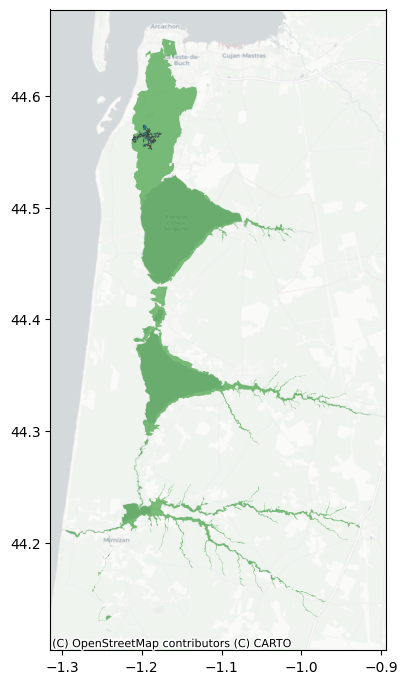

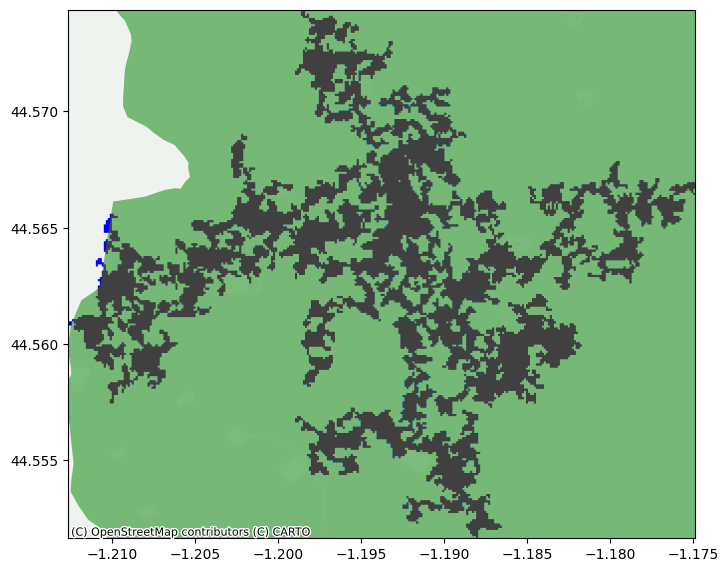

In [9]:
def plot_nat2000_example(
    sufosat_2024: gpd.GeoDataFrame, example_index: int, with_clear_cut_bounding_box: bool
) -> None:
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.tight_layout()

    sufosat_2024.loc[[example_index]]["geometry"].plot(ax=ax, color="blue")
    sufosat_2024.loc[[example_index]]["nat2000_intersection_geometry"].plot(
        ax=ax, color="red", alpha=0.5
    )
    sufosat_2024.loc[[example_index]]["nat2000_geometry"].plot(ax=ax, color="green", alpha=0.5)

    if with_clear_cut_bounding_box:
        minx, miny, maxx, maxy = sufosat_2024.loc[example_index, "geometry"].bounds
        plt.xlim(minx, maxx)
        plt.ylim(miny, maxy)

    cx.add_basemap(ax, crs="WGS84", source="CartoDB.Positron")

    plt.show()


example_index = 6500
print(sufosat_2024.loc[example_index])
plot_nat2000_example(sufosat_2024, example_index, False)
plot_nat2000_example(sufosat_2024, example_index, True)

### Check the slope of the clear cut area

- Download the data from: https://geoservices.ign.fr/rgealti
- Documentation: https://geoservices.ign.fr/sites/default/files/2021-07/DC_RGEALTI_2-0.pdf

Tile size according to documation:

| Pas | Dimension de la dalle | Nombre de nœuds |
| --- | --------------------- | --------------- |
| 1 m | 1 km sur 1 km         | 1000 sur 1000   |
| 5 m | 5 km sur 5 km         | 1000 sur 1000   |

With the `RGE ALTI® 5M` dataset, each pixel will be 5m\*5m which seems more than enough in terms of accuracy (probably too much actually).


In [10]:
# We can download the altitude data for each department.
# Then, in each department zip file, we have many 5km*5km .asc tiles available. Instead of reading them all,
# we can use the tiles shapefile to identify the relevant tiles to load.

# Download the tiles shapefile from:
# https://geoservices.ign.fr/documentation/donnees/alti/rgealti
# https://geoservices.ign.fr/sites/default/files/2024-04/RGEALTI_2-0_TA-5M_SHP_WGS84G_FRA_2024-04-30.zip
ign_tiles = gpd.read_file(
    "data/ign/RGEALTI_2-0_TA-5M_SHP_WGS84G_FRA_2024-04-30.zip!RGEALTI_2-0_TA-5M_SHP_WGS84G_FRA_2024-04-30"
)[["NOM_DALLE", "geometry"]]
ign_tiles

,NOM_DALLE,geometry
0,RGEALTI_FXX_0890_6560_MNT_LAMB93_IGN69,"POLYGON ((5.45845 46.06815, 5.46046 46.11315, ..."
1,RGEALTI_FXX_0865_6580_MNT_LAMB93_IGN69,"POLYGON ((5.14215 46.25473, 5.14392 46.29974, ..."
2,RGEALTI_FXX_0930_6600_MNT_LAMB93_IGN69,"POLYGON ((5.99519 46.41569, 5.99766 46.46068, ..."
3,RGEALTI_FXX_0900_6525_MNT_LAMB93_IGN69,"POLYGON ((5.573 45.75027, 5.57509 45.79527, 5...."
4,RGEALTI_FXX_0910_6550_MNT_LAMB93_IGN69,"POLYGON ((5.71259 45.97225, 5.71481 46.01725, ..."
...,...,...
31259,RGEALTI_MTQ_0715_1635_MNT_WGS84UTM20_MART87,"POLYGON ((-61.00293 14.73528, -61.00252 14.780..."
31260,RGEALTI_MTQ_0705_1640_MNT_WGS84UTM20_MART87,"POLYGON ((-61.09539 14.78124, -61.09499 14.826..."
31261,RGEALTI_MTQ_0735_1600_MNT_WGS84UTM20_MART87,"POLYGON ((-60.82036 14.41737, -60.81992 14.462..."
31262,RGEALTI_MTQ_0715_1640_MNT_WGS84UTM20_MART87,"POLYGON ((-61.00252 14.78046, -61.0021 14.8256..."


In [11]:
# For our example which is near "Dune of Pilat", only two tiles out of 497 are needed
# FYI, the zip file for "Gironde" is about 500MB and uncompressed, it is about 3GB.
# If we assume 100 departments, that's roughly 50GB of data to download and 300GB uncompressed 😱
# I'm thinking it could be helpful if someone would download and uncompress all the individual tiles to
# S3 so that we don't all have to download and store this much data!
ign_tiles["ign_tiles_geometry"] = ign_tiles["geometry"]
ign_dune_pilat = gpd.sjoin(
    sufosat_2024.loc[[example_index]], ign_tiles, how="left", predicate="intersects"
)
ign_dune_pilat

,geometry,area_ha,nat2000_intersection_geometry,nat2000_geometry,nat2000_area_ha,index_right,NOM_DALLE,ign_tiles_geometry
6500,"POLYGON ((-1.19861 44.57439, -1.19837 44.57439...",273.20372,"MULTIPOLYGON (((-1.19837 44.57439, -1.19837 44...","POLYGON ((-1.2522 44.17097, -1.25203 44.17031,...",272.395926,9870,RGEALTI_FXX_0365_6395_MNT_LAMB93_IGN69,"POLYGON ((-1.21783 44.52853, -1.22119 44.57347..."
6500,"POLYGON ((-1.19861 44.57439, -1.19837 44.57439...",273.20372,"MULTIPOLYGON (((-1.19837 44.57439, -1.19837 44...","POLYGON ((-1.2522 44.17097, -1.25203 44.17031,...",272.395926,9882,RGEALTI_FXX_0365_6400_MNT_LAMB93_IGN69,"POLYGON ((-1.22119 44.57347, -1.22456 44.61842..."


<Axes: >

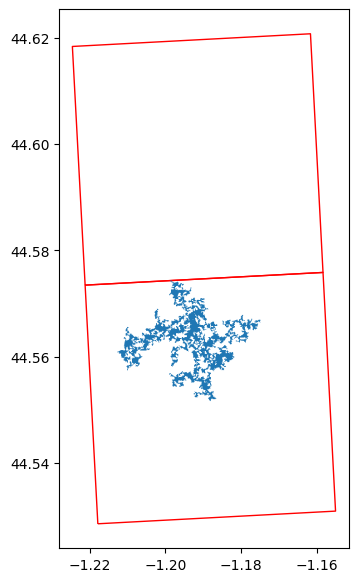

In [12]:
# Preview the two IGN tiles that should contain our clear cut
fig, ax = plt.subplots(figsize=(7, 7))
ign_dune_pilat["ign_tiles_geometry"].plot(ax=ax, facecolor="none", edgecolor="red")
ign_dune_pilat["geometry"].iloc[[0]].plot(ax=ax)

In [13]:
# Remove duplicates but keep the list of tile names to load
ign_dune_pilat = (
    ign_dune_pilat.groupby(by=ign_dune_pilat.index)
    .agg(
        {
            "geometry": "first",
            "area_ha": "first",
            "nat2000_intersection_geometry": "first",
            "nat2000_geometry": "first",
            "nat2000_area_ha": "first",
            "NOM_DALLE": list,
        }
    )
    .set_geometry("geometry")
    .set_crs(ign_dune_pilat.crs)
)
ign_dune_pilat

,geometry,area_ha,nat2000_intersection_geometry,nat2000_geometry,nat2000_area_ha,NOM_DALLE
6500,"POLYGON ((-1.19861 44.57439, -1.19837 44.57439...",273.20372,"MULTIPOLYGON (((-1.19837 44.57439, -1.19837 44...","POLYGON ((-1.2522 44.17097, -1.25203 44.17031,...",272.395926,"[RGEALTI_FXX_0365_6395_MNT_LAMB93_IGN69, RGEAL..."


In [14]:
def read_ign_elevation_raster(
    filepath: Path | str,
) -> tuple[NDArray[np.floating], rasterio.coords.BoundingBox, Affine]:
    with rasterio.open(filepath) as src:
        elevation = src.read(1)

        # Ignore nodata values
        elevation[elevation == src.nodata] = None

        return elevation, src.bounds, src.transform


elevation, elevation_bounds, elevation_transform = read_ign_elevation_raster(
    "data/ign/RGEALTI_2-0_5M_ASC_LAMB93-IGN69_D033_2021-04-19/RGEALTI/1_DONNEES_LIVRAISON_2021-11-00179/RGEALTI_MNT_5M_ASC_LAMB93_IGN69_D033/RGEALTI_FXX_0365_6400_MNT_LAMB93_IGN69.asc"
)
print(elevation)
print(elevation.shape)
print(elevation_bounds)
print(elevation_transform)

[[-1.9  -1.9  -1.9  ...  7.78  7.69  7.67]
 [-1.9  -1.9  -1.9  ...  7.8   7.67  7.73]
 [-1.9  -1.9  -1.9  ...  7.76  7.73  7.82]
 ...
 [34.27 32.32 29.8  ... 35.95 36.97 37.09]
 [35.39 33.4  31.22 ... 37.16 37.59 37.86]
 [36.77 33.8  31.31 ... 38.   37.99 38.29]]
(1000, 1000)
BoundingBox(left=364997.5, bottom=6395002.5, right=369997.5, top=6400002.5)
| 5.00, 0.00, 364997.50|
| 0.00,-5.00, 6400002.50|
| 0.00, 0.00, 1.00|


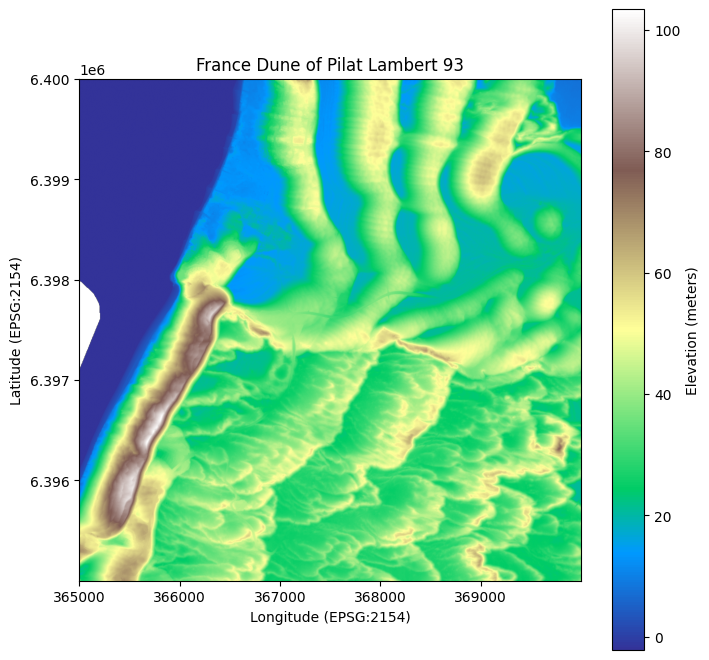

In [17]:
def plot_lambert93_raster(
    data: NDArray[np.floating],
    bounds: rasterio.coords.BoundingBox,
    title: str,
    cbar_label: str,
    cmap: str,
) -> None:
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.tight_layout()
    im = ax.imshow(
        data, cmap=cmap, extent=(bounds.left, bounds.right, bounds.bottom, bounds.top)
    )
    ax.set_title(title)
    ax.set_xlabel("Longitude (EPSG:2154)")
    ax.set_ylabel("Latitude (EPSG:2154)")
    plt.colorbar(im, ax=ax, label=cbar_label)
    plt.show()


plot_lambert93_raster(
    data=elevation,
    bounds=elevation_bounds,
    title="France Dune of Pilat Lambert 93",
    cbar_label="Elevation (meters)",
    cmap="terrain",
)

In [18]:
# We can very clearly see the "Dune of Pilat" !
# And from Google: En 2024, la Dune du Pilat culmine à 101 mètres d'altitude, soit plus de deux mètres de moins que la hauteur relevée en 2023 20 janvier 2025.
# 100 meters is quite close to our max value of 103 meters! LGTM
np.nanmax(elevation)

np.float32(103.45)

Convert elevation to slope percentage.
For the test I use the gdaldem slope function on both tiles of interest: https://gdal.org/en/stable/programs/gdaldem.html#slope.

It would be more convenient to do this from Python rather than from CLI...
But I think I need to upgrade my GDAL version for that :'c

I'm not sure which algo is best (default is Horn):

> The literature suggests Zevenbergen & Thorne to be more suited to smooth landscapes, whereas Horn's formula to perform better on rougher terrain.


In [41]:
!mkdir data/ign/slope
!gdaldem slope data/ign/RGEALTI_2-0_5M_ASC_LAMB93-IGN69_D033_2021-04-19/RGEALTI/1_DONNEES_LIVRAISON_2021-11-00179/RGEALTI_MNT_5M_ASC_LAMB93_IGN69_D033/RGEALTI_FXX_0365_6395_MNT_LAMB93_IGN69.asc data/ign/slope/RGEALTI_FXX_0365_6395_MNT_LAMB93_IGN69.asc -p 
!gdaldem slope data/ign/RGEALTI_2-0_5M_ASC_LAMB93-IGN69_D033_2021-04-19/RGEALTI/1_DONNEES_LIVRAISON_2021-11-00179/RGEALTI_MNT_5M_ASC_LAMB93_IGN69_D033/RGEALTI_FXX_0365_6400_MNT_LAMB93_IGN69.asc data/ign/slope/RGEALTI_FXX_0365_6400_MNT_LAMB93_IGN69.asc -p

mkdir: cannot create directory ‘data/ign/slope’: File exists
0...10...20...30...40...50...60...70...80...90...100 - done.
free(): invalid pointer
0...10...20...30...40...50...60...70...80...90...100 - done.
free(): invalid pointer


In [ ]:
def get_slope_percentage(tile_name: str) -> NDArray[np.floating]:
    with rasterio.open(f"data/ign/slope/{tile_name}.asc") as src:
        slope_percentage = src.read(1)

        # Ignore nodata values
        slope_percentage[slope_percentage == src.nodata] = None

        return slope_percentage


# 93% ~= 43° slope. That sounds about right
# https://fr.wikipedia.org/wiki/Dune_du_Pilat
# > En revanche, la face côté forêt, à l'abri du vent (face est), est plus raide, entre 30 et 40°
slope_percentage = get_slope_percentage("RGEALTI_FXX_0365_6400_MNT_LAMB93_IGN69")
print(f"{np.nanmax(slope_percentage) / 100:.2%}")
print(f"{math.degrees(math.atan(np.nanmax(slope_percentage) / 100)):.0f}°")

93.36%
43°


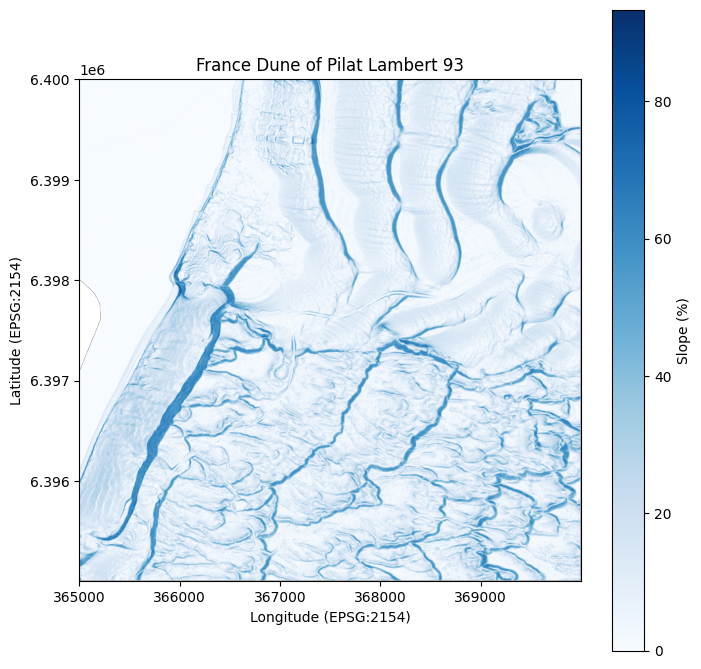

In [50]:
plot_lambert93_raster(
    data=slope_percentage,
    bounds=elevation_bounds,
    title="France Dune of Pilat Lambert 93",
    cbar_label="Slope (%)",
    cmap="Blues",
)

(6390002.5, 6400002.5)

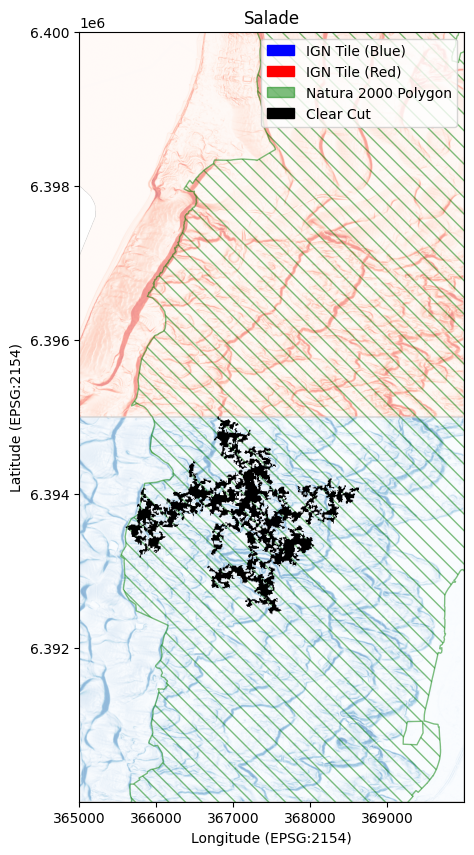

In [51]:
# Read the list of relevant raster files
ign_rasters = []
for tile_name in ign_dune_pilat.loc[example_index, "NOM_DALLE"]:
    # Get IGN tile elevation and bounds
    elevation, bounds, transform = read_ign_elevation_raster(
        f"data/ign/RGEALTI_2-0_5M_ASC_LAMB93-IGN69_D033_2021-04-19/RGEALTI/1_DONNEES_LIVRAISON_2021-11-00179/RGEALTI_MNT_5M_ASC_LAMB93_IGN69_D033/{tile_name}.asc"
    )
    # Compute the slope
    slope = get_slope_percentage(tile_name)
    # Add raster to the list
    ign_rasters.append(
        {"elevation": elevation, "slope": slope, "bounds": bounds, "transform": transform}
    )

# Plot both IGN tiles
fig, ax = plt.subplots(figsize=(5, 10))

ax.set_title("Salade")
ax.set_xlabel("Longitude (EPSG:2154)")
ax.set_ylabel("Latitude (EPSG:2154)")
for ign_raster, cmap in zip(ign_rasters, ["Blues", "Reds"], strict=True):
    bounds = ign_raster["bounds"]
    ax.imshow(
        ign_raster["slope"],
        extent=(bounds.left, bounds.right, bounds.bottom, bounds.top),
        cmap=cmap,
        alpha=0.5,
    )


# Plot the Natura 2000 area
ign_dune_pilat["nat2000_geometry"].set_crs("EPSG:4326").to_crs("EPSG:2154").plot(
    ax=ax,
    hatch="\\\\",
    edgecolor="green",
    facecolor="none",
    alpha=0.5,
)

# Plot the clear cut
ign_dune_pilat.to_crs("EPSG:2154").plot(ax=ax, color="black")


# Define legend patches
legend_patches = [
    mpatches.Patch(color="blue", label="IGN Tile (Blue)"),
    mpatches.Patch(color="red", label="IGN Tile (Red)"),
    mpatches.Patch(color="green", alpha=0.5, label="Natura 2000 Polygon"),
    mpatches.Patch(color="black", label="Clear Cut"),
]

# Add legend to the plot
ax.legend(handles=legend_patches, loc="upper right")


plt.xlim(
    min(ign_raster["bounds"].left for ign_raster in ign_rasters),
    max(ign_raster["bounds"].right for ign_raster in ign_rasters),
)
plt.ylim(
    min(ign_raster["bounds"].bottom for ign_raster in ign_rasters),
    max(ign_raster["bounds"].top for ign_raster in ign_rasters),
)

In [56]:
# Compute the slope stats for each raster tile
# In this case it's a bit particuliar because we only touch 3 border pixels from the red tile
# and the border pixels don't have a slope value assigned by the gdal algorithm (instead, it's set to nodata = -9999)
for ign_raster in ign_rasters:
    ign_raster["slope_stats"] = zonal_stats(
        ign_dune_pilat.to_crs("EPSG:2154").loc[example_index, "geometry"],
        ign_raster["slope"],
        affine=ign_raster["transform"],
        nodata=-9999,
    )
    print(ign_raster["slope_stats"])

[{'min': 0.03534940630197525, 'max': 66.05731201171875, 'mean': 13.44957706089963, 'count': 55534}]
[{'count': 0, 'min': None, 'max': None, 'mean': None}]


In [57]:
# Compute the mean slope for this clear cut
# mean across tiles = sum(count * mean) / total count
# NOTE: I'm not sure it makes much sense to compute the mean slope for a clear cut of 273 hectares...
mean_slope = sum(
    ign_raster["slope_stats"][0]["count"] * (ign_raster["slope_stats"][0]["mean"] or 0)
    for ign_raster in ign_rasters
) / sum(ign_raster["slope_stats"][0]["count"] for ign_raster in ign_rasters)
mean_slope

13.44957706089963

<span style="color: red;">To be continued 🚀</span>


## Statistics


In [67]:
# Number of abusive clear cuts
abusive_clear_cuts = sufosat_2024[
    # Area >= 10 hectares
    (sufosat_2024["area_ha"] >= 10)
    |
    # Area >= 2 hectares within a protected natural area (e.g., Natura 2000)
    (sufosat_2024["nat2000_area_ha"] >= 2)
    # TODO Area >= 2 hectares and slope >= 30%
]
abusive_clear_cuts

,geometry,area_ha,nat2000_intersection_geometry,nat2000_geometry,nat2000_area_ha
6,"POLYGON ((-1.21467 43.60242, -1.21455 43.60242...",2.001177,"MULTIPOLYGON (((-1.21455 43.60242, -1.21455 43...","POLYGON ((-1.71413 43.34312, -1.71373 43.34303...",2.001177
21,"POLYGON ((0.08112 47.46136, 0.08124 47.46136, ...",2.005412,"MULTIPOLYGON (((0.08124 47.46136, 0.08124 47.4...","POLYGON ((0.39305 47.38674, 0.39309 47.38577, ...",2.005412
30,"POLYGON ((4.16762 48.53982, 4.16774 48.53982, ...",2.007476,"POLYGON ((4.16774 48.53982, 4.16774 48.53964, ...","POLYGON ((4.18042 48.5389, 4.17954 48.53867, 4...",2.007476
66,"POLYGON ((1.61069 47.32904, 1.61093 47.32904, ...",2.020142,"POLYGON ((1.61093 47.32904, 1.61093 47.32895, ...","POLYGON ((1.48826 47.59402, 1.48335 47.601, 1....",2.020142
74,"POLYGON ((3.83456 44.2094, 3.83468 44.2094, 3....",2.021833,"POLYGON ((3.83468 44.2094, 3.83468 44.20931, 3...","POLYGON ((2.23693 42.42761, 2.23449 42.42619, ...",2.021833
...,...,...,...,...,...
6496,"POLYGON ((-1.18134 44.59514, -1.18086 44.59514...",66.237954,"MULTIPOLYGON (((-1.18086 44.59514, -1.18086 44...","POLYGON ((-1.2522 44.17097, -1.25203 44.17031,...",66.237954
6497,"POLYGON ((-1.19201 44.54103, -1.19189 44.54103...",67.776518,"MULTIPOLYGON (((-1.19189 44.54103, -1.19189 44...","POLYGON ((-1.2522 44.17097, -1.25203 44.17031,...",67.776518
6498,"POLYGON ((-0.4337 44.15538, -0.43346 44.15538,...",75.445972,None,None,NaN
6499,"POLYGON ((-0.77599 44.62886, -0.77575 44.62886...",87.825707,None,None,NaN


In [68]:
# Sum of clear cut hectares
f"{abusive_clear_cuts['area_ha'].sum():.0f} ha"

'13206 ha'